## ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Pandas for EDA
by [@josephofiowa](https://twitter.com/josephofiowa)
 
<!---
This assignment was developed by Joseph Nelson

Questions? Comments?
1. Log an issue to this repo to alert me of a problem.
2. Suggest an edit yourself by forking this repo, making edits, and submitting a pull request with your changes back to our master branch.
3. Hit me up on Slack @sonylnagale
--->

# Pandas Unit Lab

**Woo!** We've made it to the end of our Pandas Unit. Let's put our skills to the test.

We're going to explore data from the top movies according to IMDB. This is a guided question-and-response lab where some areas are specific asks and others are open ended for you to explore.

In this lab, we will:
- Use `movie_app.py` to obtain relevant moving rating data
- Leverage Pandas to conduct exploratory data analysis, including:
    - Assess data integrity
    - Create exploratory visualizations
    - Produce insights on top actors/actresses across films
    
Let's get going!

## The Dataset

We'll work with a dataset on the top [100 movies](https://www.imdb.com/search/title?count=100&groups=top_1000&sort=user_rating), as rated by IMDB.


Specifically, we have a CSV that contains:
- IMDB star rating
- Movie title
- Year
- Content rating
- Genre
- Duration
- Gross

_[Details available at the above link]_


### Import our necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

### Read in the dataset

First, read in the dataset, called `imdb_100.csv` into a DataFrame called "movies."

In [2]:
movies = pd.read_csv('./data/imdb_100.csv')

In [3]:
movies.shape

(100, 7)

## Check the dataset basics

Let's first explore our dataset to verify we have what we expect.

Print the first five rows.

In [4]:
movies.head()

,star_rating,title,year,content_rating,genre,duration,gross
0,9.3,The Shawshank Redemption,1994,R,Drama,142,1963330
1,9.2,The Godfather,1972,R,Crime,175,28341469
2,9.0,The Dark Knight,2008,PG-13,Action,152,1344258
3,9.0,The Godfather: Part II,1974,R,Crime,202,134966411
4,8.9,Pulp Fiction,1994,R,Crime,154,1935047


How many rows and columns are in the datset?

In [5]:
movies.shape

(100, 7)

What are the column names?

In [6]:
movies.columns

Index(['star_rating', 'title', 'year', 'content_rating', 'genre', 'duration',
       'gross'],
      dtype='object')

How many unique genres are there?

In [7]:
movies.genre.nunique()

12

How many movies are there per genre?

In [8]:
movies.genre.value_counts()

Crime                  20
Drama                  17
Action                 17
Animation              10
Adventure               9
Drama                   8
Comedy                  6
Biography               5
Western                 3
Horror                  2
Mystery                 2
Comedy                  1
Name: genre, dtype: int64

## Obtain more data (with an API call)!

Let's take advantage of our `movie_app.py` program to obtain data from OMDBAPi on movie ratings. This will enable us to answer the question: **How do Rotten Tomato scores compare to IMDB ratings?** Where do Rotten Tomato critics most disagree with IMDB reviews?

We're going to write a function that allows us to obtain the Rotten Tomato reviews on the top 100 IMDB movies. We will store these ratings in a new column in our `movies` DataFrame.

First, we need to load `movie_app.py` into a Jupyter Notebook cell.

In [9]:
# %load movie_app.py
import requests

class OMDBError(Exception):
    """
    OMDBError represents an error returned by the OMDB API.
    """
    pass

class Movie(object):
    """
    Movie objects contain all OMDB information about a particular movie,
    including the title and rating.
    """

    def __init__(self, movie_data):

        # Store the raw data from OMDB in this object so that we can use the
        # data in the getter functions.
        self.omdb_data = movie_data

    def get_movie_title(self):
        """
        get_movie_title is a getter function that returns the movie title.
        """

        # Return the title key from the OMDB data.
        return self.omdb_data["Title"]

    def get_movie_rating(self, source="Rotten Tomatoes"):
        """
        get_movie_rating is a getter function that returns the Rotten Tomatoes rating.
        """

        # There can be multiple ratings for each movie, so they are stored as a
        # list of ratings, each with a source and a rating. By default, we are
        # only interested in Rotten Tomatoes ratings, so we loop through each
        # rating and return it if the source is Rotten Tomatoes.
        for ratings in self.omdb_data["Ratings"]:
            if ratings["Source"] == source:
                return ratings["Value"]

        # If no matching rating is found, we will raise an error.
        return "-  Wait - Rating for source {0} was not found!".format(source))

class OMDB(object):
    """
    OMDB objects represent clients to the OMDB API. It has helper methods for
    performing functions on the API.
    """
    def __init__(self, apikey):
        # Store the API key so it may be used later to build the authenticated URL.
        self.apikey = apikey
        self.url = "http://www.omdbapi.com/?"

    def call_api(self, **kwargs):
        """
        call_api uses the provided parameters to create a URL to the OMDB API,
        call the API, parse the results, and return the parsed JSON data.

        If the API returns an error, the error is raised as an exception.
        """

        # Add api key to dictionary of parameters to send to OMDB.
        kwargs["apikey"] = self.apikey

        # Call the API by requesting the url. Use json() to decode the raw JSON data.
        response_data = requests.get(self.url, kwargs).json()

        # Check for an error and throw an exception if needed
        if "Error" in response_data:
            raise OMDBError(response_data["Error"])

        # Return the decoded data
        return response_data

    def get_movie(self, movie_query):
        """
        Get a movie object containing all the data for a single movie. Returns
        a single movie object.
        """
        # Call the API, passing the movie_query as "t" (by title).
        movie_data = self.call_api(t=movie_query)
    
        # Create a Movie with the raw results from the API call.
        return Movie(movie_data)

    def search(self, movie_query):
        """
        Search for movies based on keywords. Returns list of dictionaries.
        """
        # Call the API, passing the movie_query as "s" (by search).
        movie_dictionaries = self.call_api(s=movie_query)

        # Return the list of movie dictionaries.
        return movie_dictionaries["Search"]

def get_apikey():
    """
    Read API key from file on disk.
    """

    # Open file in read mode (r).
    with open("omdb-api-key.txt", "r") as file:

        # Read the file into a variable (key).
        key = file.read()

        # Strip any whitespace characters such as a newline that may be present
        # in the file.
        key = key.strip()

        # Return the key
        return key

def list_search_results(movie_to_look_up):
    """
    Prompt for search term and print list of matching movies.
    """

    # Read the API key from disk.
    apikey = get_apikey()

    # Create OMDB client with provided API key.
    omdb = OMDB(apikey)

    # Get results from OMDB API. If OMDB error occurs, print the error message and exit.
    try:
        matching_movie_list = omdb.search(movie_to_look_up)
    except OMDBError as err:
        print("OMDB Error: {0}".format(err))
        return

    # Extract titles from search result list with list comprehension (each
    # result is a dictionary).
    movie_titles = [each_movie["Title"] for each_movie in matching_movie_list]

    # Loop through list of titles and print them (indented with 4 spaces).
    for title in movie_titles:
        print("    " + title)

def return_single_movie_object(movie_to_look_up):
    """
    Prompt for movie title and print Rotten Tomatoes rating.
    """
    
    # Read the API key from disk.
    apikey = get_apikey()

    # Create OMDB client with provided API key.
    omdb = OMDB(apikey)

    # Get Movie object. If OMDB error occurs, print the error message and exit.
    try:
        my_movie_object = omdb.get_movie(movie_to_look_up)
        return my_movie_object
    except OMDBError as err:
        print("OMDB Error: {0}".format(err))
        return

def print_single_movie_rating(movie_query):

    my_movie = return_single_movie_object(movie_query)

    # Print the rating. Note that we have to escape the quotes around the movie
    # title because those quotes are inside a string that also uses quotes.
    print("The rating for \"{0}\" is {1}.".format(my_movie.get_movie_title(), my_movie.get_movie_rating()))
    

def return_single_movie_rating(movie_query):
    my_movie = return_single_movie_object(movie_query)
    # Return the rating. Note we are only returning the percentage.
    return(my_movie.get_movie_rating())
    
    
def print_all_ratings(movie_list):
    for movie in movie_list: 
        movie_object = return_single_movie_object(movie)
        print("The movie", movie_object.get_movie_title(), "has a rating of", movie_object.get_movie_rating())

def main():
    """
    Main is the entrypoint into the program, and it calls into the search or
    ratings functions depending on what the user decides to do.
    """

    # Empty (for now!)

if __name__ == "__main__":
    main()

Notice a few changes!

We've provided you with a new function, `return_single_movie_rating(movie_query)`, which is very similar to the  `print_single_movie_rating(movie_query)` function you've written. The key difference is our new function *returns* the Rotten Tomato value so we can store it.



Here's the new function:

```python
def return_single_movie_rating(movie_query):
    my_movie = return_single_movie_object(movie_query)
    # Return the rating. Note we are only returning the percentage.
    return(my_movie.get_movie_rating())
```

A bit ununituitive note: you need to re-run the above cell after loading the script. Loading the script does not also instantiate the script. So, we must do so by running the cell.

Second, let's test out this new function by querying a single movie

In [10]:
# let's run the function on one of the world's best movies
movie_name = "Flubber"
return_single_movie_rating(movie_name)

'24%'

Great! We have a function that returns the Rotten Tomatoes score for a given movie. 

Now, we need to pass the movies from our DataFrame to this function one-by-one, and store the result of this function in a list.

So, third, write a loop that prints out each movie title from your dataframe.

In [11]:
for name in movies.title:
    print(name)

The Shawshank Redemption
The Godfather
The Dark Knight
The Godfather: Part II
Pulp Fiction
Schindler's List
The Lord of the Rings: The Return of the King
The Good, the Bad and the Ugly
12 Angry Men
Avengers: Infinity War
The Lord of the Rings: The Fellowship of the Ring
Inception
Forrest Gump
Fight Club
Star Wars: Episode V - The Empire Strikes Back
The Matrix
Goodfellas
The Lord of the Rings: The Two Towers
One Flew Over the Cuckoo's Nest
Seven Samurai
Interstellar
The Silence of the Lambs
Lon: The Professional
Se7en
Star Wars: Episode IV - A New Hope
Saving Private Ryan
Spirited Away
The Usual Suspects
City of God
Life Is Beautiful
It's a Wonderful Life
City Lights
Coco
The Departed
The Lion King
Back to the Future
Gladiator
Whiplash
The Prestige
Raiders of the Lost Ark
Alien
Apocalypse Now
The Green Mile
Psycho
Terminator 2
Memento
American History X
The Intouchables
Once Upon a Time in the West
The Pianist
Casablanca
Rear Window
Grave of the Fireflies
Cinema Paradiso
Dangal
Sunset

Nice! So far, we are able to:

- Pass a movie name to a function (`return_single_movie_rating()`) to obtain a rating value
- Loop through all the titles in our `movies` DataFrame


Fourth: it's time to combine these steps, and store those ratings in a list!

In [12]:
# declare empty list to hold our ratings
rotten_ratings = list()

In [13]:
# loop through each movie in the DataFrame, and pass that name to our function
# store the result of that function, using append()` in our rotten_ratings list
for name in movies.title:
    
    # try to find the Rotten Tomato rating
    try:
        rotten_ratings.append(return_single_movie_rating(name))
        
    # append a null if not found
    except:
        rotten_ratings.append(np.nan)

OMDB Error: Movie not found!
OMDB Error: Movie not found!
OMDB Error: Movie not found!
OMDB Error: Movie not found!
OMDB Error: Movie not found!


**Great work!**

Fifth, and certainly not least, let's create a column to store that new list of data!

In [14]:
movies['rotten_rating'] = rotten_ratings

## Checking the basics [continued] and cleaning

Now that we have a new dataset, let's keep exploring.

Print the first five rows again, just to verify everything is looking ok.

In [15]:
movies.head()

,star_rating,title,year,content_rating,genre,duration,gross,rotten_rating
0,9.3,The Shawshank Redemption,1994,R,Drama,142,1963330,91%
1,9.2,The Godfather,1972,R,Crime,175,28341469,98%
2,9.0,The Dark Knight,2008,PG-13,Action,152,1344258,94%
3,9.0,The Godfather: Part II,1974,R,Crime,202,134966411,97%
4,8.9,Pulp Fiction,1994,R,Crime,154,1935047,94%


Check for null values in all of your columns.

In [16]:
movies.isnull().sum()

star_rating       0
title             0
year              0
content_rating    0
genre             0
duration          0
gross             0
rotten_rating     7
dtype: int64

Check our datatypes. Notice anything potentially problematic?

In [17]:
movies.dtypes

star_rating       float64
title              object
year                int64
content_rating     object
genre              object
duration            int64
gross               int64
rotten_rating      object
dtype: object

Because `rotten_rating` contains a % sign, the datatype is an object. We need to clean this up!

We need to strip the "%" sign from every entry in the `rotten_ratings` column. This is a grea opportunity to practice apply functions!

First, we'll grab a single entry from the relevant column in our DataFrame.

In [18]:
movies.rotten_rating[0]

'91%'

Write code that strips a string of its % sign. 

In [19]:
movies.rotten_rating[0].strip('%')

'91'

Now, turn the above code into a function that accepts any given text (a single string **not** a list of strings) with a % sign, and returns that text formatted as an integer and without the % sign.

In [20]:
def clean_percents(string_with_percent):
    try:
        # if the value can be converted to a string, we will strip the '%'
        # convert the result of that to an integer then return
        return int(str(string_with_percent).strip('%'))
    except:
        # otherwise, we'll return the same null value we had
        return np.nan

**Test** our function on a single value.

In [21]:
clean_percents(movies.rotten_rating[0])

91

Now, if we get the desired result, we can *apply* this function to the whole column of interest. We will store the result on top of the old column entries.

In [22]:
movies.rotten_rating = movies.rotten_rating.apply(clean_percents)

Did it work?

In [23]:
movies.dtypes

star_rating       float64
title              object
year                int64
content_rating     object
genre              object
duration            int64
gross               int64
rotten_rating     float64
dtype: object

Yes!

## Exploratory data analysis

Let's transition to asking and answering some questions with our data.

What are the top five R-Rated movies?

*hint: Boolean filters needed! Then sorting!*

In [24]:
movies[movies.content_rating == 'R'].sort_values(by='star_rating', ascending=False).head()

,star_rating,title,year,content_rating,genre,duration,gross,rotten_rating
0,9.3,The Shawshank Redemption,1994,R,Drama,142,1963330,91.0
1,9.2,The Godfather,1972,R,Crime,175,28341469,98.0
3,9.0,The Godfather: Part II,1974,R,Crime,202,134966411,97.0
4,8.9,Pulp Fiction,1994,R,Crime,154,1935047,94.0
5,8.9,Schindler's List,1993,R,Biography,195,534858444,97.0


What is the average Rotten Tomato score for the top 100 IMDB films?

In [25]:
movies.rotten_rating.mean()

91.40860215053763

What is the Five Number Summary like for top rated films as per IMDB? Is it skewed?

In [26]:
movies.star_rating.describe()

count    100.000000
mean       8.524000
std        0.207009
min        8.300000
25%        8.400000
50%        8.500000
75%        8.600000
max        9.300000
Name: star_rating, dtype: float64

The average is *slightly* higher than the median, so there's a small positive skew.

Create your own question...then answer it!

In [27]:
# correlation between star rating and Rotten Tomato rating?
movies.corr()

,star_rating,year,duration,gross,rotten_rating
star_rating,1.000000,0.009537,0.348841,0.136235,0.041449
year,0.009537,1.000000,0.107081,0.015215,-0.100059
duration,0.348841,0.107081,1.000000,0.112082,-0.161066
gross,0.136235,0.015215,0.112082,1.000000,-0.045481
rotten_rating,0.041449,-0.100059,-0.161066,-0.045481,1.000000


**Challenge:** Create a column that is the ratio between Rotten Tomato rating vs IMDB rating. What film has the highest IMDB : Rotten Tomato ratio? The lowest?

*[skip this if you are low on time]*

In [28]:
movies['imdb_rotten_ratio'] = movies.star_rating / movies.rotten_rating

In [29]:
movies.sort_values('imdb_rotten_ratio', ascending=False).head(1)

,star_rating,title,year,content_rating,genre,duration,gross,rotten_rating,imdb_rotten_ratio
12,8.8,Forrest Gump,1994,PG-13,Drama,142,1401164,72.0,0.122222


On average, IMDB viewers liked Interstellar an outsized amount more than Rotten Tomato reviewers.

In [30]:
movies.sort_values('imdb_rotten_ratio', ascending=True).head(1)

,star_rating,title,year,content_rating,genre,duration,gross,rotten_rating,imdb_rotten_ratio
82,8.3,Toy Story,1995,R,Animation,81,83471511,100.0,0.083


On average, Rotten Tomato reviewers liked Interstellar an outsized amount more than IMDB reviewers.

## Exploratory data analysis with visualizations

For each of these prompts, create a plot to visualize the answer. Consider what plot is *most appropriate* to explore the given prompt.


What is the relationship between IMDB ratings and Rotten Tomato ratings?

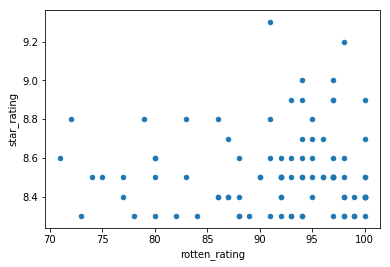

In [31]:
movies.plot(kind='scatter', x='rotten_rating', y='star_rating')

What is the relationship between IMDB rating and movie duration?

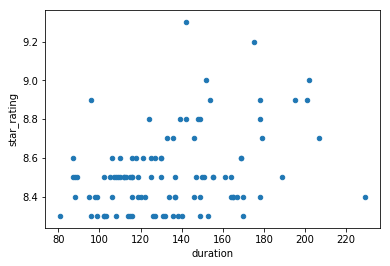

In [32]:
movies.plot(kind='scatter', x='duration', y='star_rating')

How many movies are there in each genre category? (Remember to create a plot here)

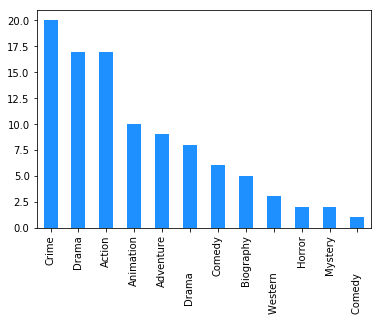

In [33]:
movies['genre'].value_counts().plot(kind='bar', color='dodgerblue')

What does the distribution of Rotten Tomato ratings look like?

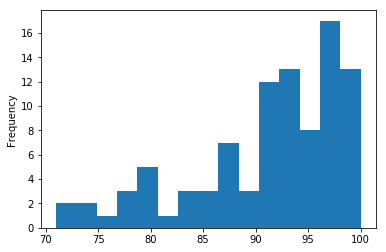

In [34]:
movies.rotten_rating.plot(kind='hist', bins=15)

## Bonus

There are many things left unexplored! Consider investigating something about gross revenue and genres.

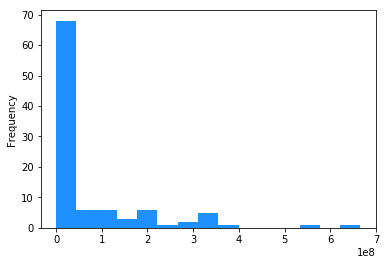

In [35]:
movies.gross.plot(kind='hist', bins=15, color='dodgerblue')

In [36]:
# top 10 grossing films
movies.sort_values(by='gross', ascending=False).head(10)

,star_rating,title,year,content_rating,genre,duration,gross,rotten_rating,imdb_rotten_ratio
18,8.7,One Flew Over the Cuckoo's Nest,1975,R,Drama,133,665845272,94.0,0.092553
5,8.9,Schindler's List,1993,R,Biography,195,534858444,97.0,0.091753
13,8.8,Fight Club,1999,R,Drama,139,377845905,79.0,0.111392
34,8.5,The Lion King,1994,G,Animation,88,342551365,93.0,0.091398
24,8.6,Star Wars: Episode IV - A New Hope,1977,PG,Action,121,330252182,93.0,0.092473
48,8.5,Once Upon a Time in the West,1968,PG-13,Western,164,322740140,98.0,0.086735
20,8.6,Interstellar,2014,PG-13,Adventure,169,315544750,71.0,0.121127
68,8.4,Once Upon a Time in America,1984,R,Crime,229,312900000,86.0,0.097674
22,8.6,Lon: The Professional,1994,R,Crime,110,292576195,NaN,NaN
28,8.6,City of God,2002,R,Crime,130,290475067,91.0,0.094505


In [37]:
# correlation between star rating and gross value? (little, negative for Rotten)
movies.corr()

,star_rating,year,duration,gross,rotten_rating,imdb_rotten_ratio
star_rating,1.000000,0.009537,0.348841,0.136235,0.041449,0.224895
year,0.009537,1.000000,0.107081,0.015215,-0.100059,0.096528
duration,0.348841,0.107081,1.000000,0.112082,-0.161066,0.233550
gross,0.136235,0.015215,0.112082,1.000000,-0.045481,0.078865
rotten_rating,0.041449,-0.100059,-0.161066,-0.045481,1.000000,-0.959381
imdb_rotten_ratio,0.224895,0.096528,0.233550,0.078865,-0.959381,1.000000
